In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device



(<Figure size 1000x600 with 1 Axes>, <Axes: >)

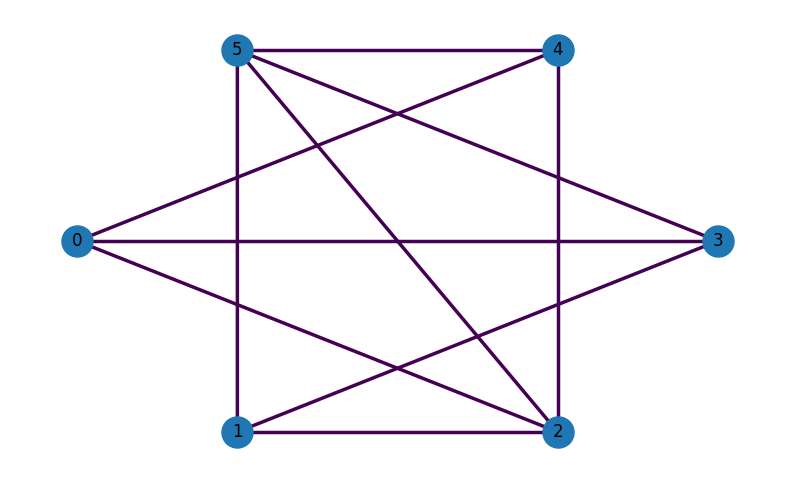

In [2]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [3]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The property `qubo` translates the problem into a binary Qubo problem.
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.qubo

/home/ziqguo/conda/envs/qaoa/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [4]:
pprint(maxcut_qubo.asdict())

{'constant': 0,
 'metadata': {},
 'n': 6,
 'problem_instance': {'G': {'directed': False,
                            'graph': {},
                            'links': [{'source': 0, 'target': 2},
                                      {'source': 0, 'target': 3},
                                      {'source': 0, 'target': 4},
                                      {'source': 1, 'target': 2},
                                      {'source': 1, 'target': 3},
                                      {'source': 1, 'target': 5},
                                      {'source': 2, 'target': 4},
                                      {'source': 2, 'target': 5},
                                      {'source': 3, 'target': 5},
                                      {'source': 4, 'target': 5}],
                            'multigraph': False,
                            'nodes': [{'id': 0},
                                      {'id': 1},
                                      {'id': 2},
             

In [5]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -6.0, Solution: ['001110', '110001']


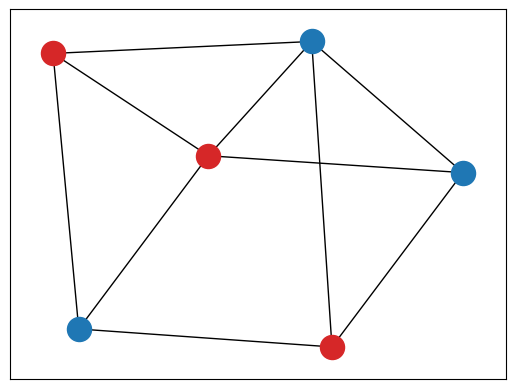

In [6]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

In [7]:
# initialize model with default configurations
q = QAOA()

In [8]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

In [9]:
q.compile(maxcut_qubo)

In [10]:
q.optimize()

In [11]:
opt_results = q.result

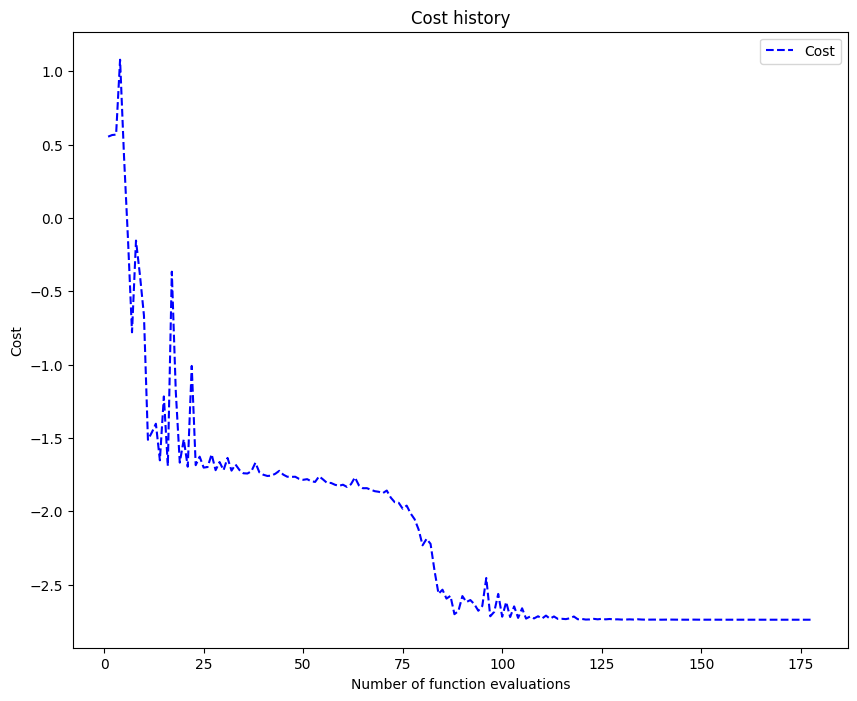

In [12]:
# print the cost history
fig, ax = opt_results.plot_cost()

In [13]:
pprint(opt_results.optimized)

{'angles': [0.041620023048, 0.334287474372, 2.249483171739, 1.154889993818],
 'cost': -2.738491250087,
 'eval_number': 177,
 'job_id': 'ceaabb26-ea0e-4ebf-964a-fcd711452b52',
 'measurement_outcomes': array([-0.01269122-0.00705944j, -0.02594769-0.05407319j,
       -0.05246251-0.01523637j, -0.05415351+0.08178868j,
       -0.02720899+0.00471941j, -0.01018133+0.06345017j,
       -0.01276735+0.08581239j, -0.05671219+0.19174231j,
       -0.02594769-0.05407319j, -0.00939587+0.03036637j,
       -0.00193492+0.03103254j,  0.00904362+0.13104619j,
       -0.12593175+0.13120159j, -0.04449613+0.15902308j,
       -0.03030679+0.13540892j, -0.01276735+0.08581239j,
       -0.05246251-0.01523637j, -0.00193492+0.03103254j,
       -0.05905597+0.10362416j, -0.12329176+0.18643539j,
       -0.01193028+0.0671411j ,  0.0509246 +0.07259569j,
       -0.04449613+0.15902308j, -0.01018133+0.06345017j,
       -0.05415351+0.08178868j,  0.00904362+0.13104619j,
       -0.12329176+0.18643539j, -0.05029118+0.12563697j,
  

In [14]:
variational_params = q.optimizer.variational_params

In [15]:
#create the optimized QAOA circuit for qiskit backend
optimized_angles = opt_results.optimized['angles']
variational_params.update_from_raw(optimized_angles)
optimized_circuit = q.backend.qaoa_circuit(variational_params)

#print the optimized QAOA circuit for qiskit backend
optimized_circuit.draw()

┌───┐                                                ┌──────────────┐»
q0_0: ┤ H ├─■───────────■───────────────────────■──────────┤ Rx(-0.08324) ├»
      ├───┤ │           │                       │          └──────────────┘»
q0_1: ┤ H ├─┼───────────┼───────────■───────────┼─────────────■────────────»
      ├───┤ │ZZ(4.499)  │           │ZZ(4.499)  │             │            »
q0_2: ┤ H ├─■───────────┼───────────■───────────┼─────────────┼────────────»
      ├───┤             │ZZ(4.499)              │             │ZZ(4.499)   »
q0_3: ┤ H ├─────────────■───────────────────────┼─────────────■────────────»
      ├───┤                                     │ZZ(4.499)                 »
q0_4: ┤ H ├─────────────────────────────────────■──────────────────────────»
      ├───┤                                                                »
q0_5: ┤ H ├────────────────────────────────────────────────────────────────»
      └───┘                                                                »
«                                                                              »
«q0_0: ──────────────────────────────────────────────────────────■─────────────»
«                  ┌──────────────┐                              │             »
«q0_1: ─■──────────┤ Rx(-0.08324) ├──────────────────────────────┼─────────────»
«       │          └──────────────┘            ┌──────────────┐  │ZZ(2.3098)   »
«q0_2: ─┼─────────────■─────────────■──────────┤ Rx(-0.08324) ├──■─────────────»
«       │             │             │          └──────────────┘┌──────────────┐»
«q0_3: ─┼─────────────┼─────────────┼─────────────■────────────┤ Rx(-0.08324) ├»
«       │             │ZZ(4.499)    │             │            └──────────────┘»
«q0_4: ─┼─────────────■─────────────┼─────────────┼───────────────■────────────»
«       │ZZ(4.499)                  │ZZ(4.499)    │ZZ(4.499)      │ZZ(4.499)   »
«q0_5: ─■───────────────────────────■─────────────■───────────────■────────────»
«                                                                              »
«                                                ┌──────────────┐             »
«q0_0: ──■───────────────────────────■───────────┤ Rx(-0.66857) ├─────────────»
«        │                           │           └──────────────┘             »
«q0_1: ──┼──────────────■────────────┼─────────────■──────────────■───────────»
«        │              │ZZ(2.3098)  │             │              │           »
«q0_2: ──┼──────────────■────────────┼─────────────┼──────────────┼───────────»
«        │ZZ(2.3098)                 │             │ZZ(2.3098)    │           »
«q0_3: ──■───────────────────────────┼─────────────■──────────────┼───────────»
«      ┌──────────────┐              │ZZ(2.3098)                  │           »
«q0_4: ┤ Rx(-0.08324) ├──────────────■────────────────────────────┼───────────»
«      ├──────────────┤                                           │ZZ(2.3098) »
«q0_5: ┤ Rx(-0.08324) ├───────────────────────────────────────────■───────────»
«      └──────────────┘                                                       »
«                                                                   »
«q0_0: ─────────────────────────────────────────────────────────────»
«      ┌──────────────┐                                             »
«q0_1: ┤ Rx(-0.66857) ├─────────────────────────────────────────────»
«      └──────────────┘             ┌──────────────┐                »
«q0_2: ──■──────────────■───────────┤ Rx(-0.66857) ├────────────────»
«        │              │           └──────────────┘┌──────────────┐»
«q0_3: ──┼──────────────┼─────────────■─────────────┤ Rx(-0.66857) ├»
«        │ZZ(2.3098)    │             │             └──────────────┘»
«q0_4: ──■──────────────┼─────────────┼───────────────■─────────────»
«                       │ZZ(2.3098)   │ZZ(2.3098)     │ZZ(2.3098)   »
«q0_5: ─────────────────■─────────────■───────────────■─────────────»
«                                                                   »
« 